<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/lern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
!pip install pandas-ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [166]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from scipy.stats import boxcox
import scipy
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

**Define functions**

In [197]:
def get_largest_value_array(Data, columns):
    # Subset the data frame to only include the specified columns
    sub_data = Data[columns]

    # Use the apply() function with the max() function to find the maximum value in each row of the subsetted data frame
    max_values = sub_data.apply(max, axis=1)

    # Create a new array that takes the maximum value from step 2 for each row of the original data frame
    max_array = np.array(max_values)
    
    return max_array
  
def get_smallest_value_array(Data, columns):
    # Subset the data frame to only include the specified columns
    sub_data = Data[columns]

    # Use the min() function to find the minimum value in each row of the subsetted data frame
    min_values = sub_data.min(axis=1)

    # Create a new array that takes the minimum value from step 2 for each row of the original data frame
    min_array = np.array(min_values)
    
    return min_array

def get_array_bo_greater_than_bc(Data):
    # Use np.where() to compare the "BO" and "BC" columns, return 1 if "BO" < "BC", and 0 otherwise
    result_array = np.where(Data["BO"] < Data["BC"], 1, 0)
    
    return result_array

def generate_dataframe(func, start, end, step, data, name):
    result_df = pd.DataFrame()

    for param in np.arange(start, end, step):
        result_array = func(param, data)
        temp_df = pd.DataFrame(result_array, columns=[name+str(param)])
        result_df = pd.concat([result_df, temp_df], axis=1)

    return result_df


def equalize_dataframes(df1, df2):
    row_count_diff = len(df1) - len(df2)
    
    if row_count_diff > 0:
        # df1 has more rows, remove the first rows from df1
        df1 = df1.iloc[row_count_diff:]
    elif row_count_diff < 0:
        # df2 has more rows, remove the first rows from df2
        df2 = df2.iloc[-row_count_diff:]
    
    return df1, df2
def drop_rows_with_nan(df):
    # drop any row with NaN values in the specified columns
    df.dropna(subset=df.columns, inplace=True)
    
    # reset the index after dropping rows
    df.reset_index(drop=True, inplace=True)
    
    # return the cleaned data frame
    return df

**Load Data**

In [63]:
Data = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
Data['Date'] = pd.to_datetime(Data['Date'])
Data['Time'] = pd.to_datetime(Data['Time'])
print(Data)

            Date                Time       BO       BH       BL       BC  \
0     2005-05-02 2023-05-24 00:00:00  1.28520  1.28520  1.28400  1.28440   
1     2005-05-02 2023-05-24 01:00:00  1.28440  1.28480  1.28390  1.28420   
2     2005-05-02 2023-05-24 02:00:00  1.28430  1.28540  1.28410  1.28510   
3     2005-05-02 2023-05-24 03:00:00  1.28510  1.28590  1.28500  1.28510   
4     2005-05-02 2023-05-24 04:00:00  1.28520  1.28590  1.28490  1.28550   
...          ...                 ...      ...      ...      ...      ...   
93079 2020-04-29 2023-05-24 18:00:00  1.08620  1.08851  1.08611  1.08713   
93080 2020-04-29 2023-05-24 19:00:00  1.08711  1.08823  1.08659  1.08748   
93081 2020-04-29 2023-05-24 20:00:00  1.08747  1.08788  1.08691  1.08708   
93082 2020-04-29 2023-05-24 21:00:00  1.08708  1.08740  1.08699  1.08714   
93083 2020-04-29 2023-05-24 22:00:00  1.08728  1.08760  1.08727  1.08743   

           BCh       AO       AH       AL       AC      ACh  
0     -0.00080  1.28540  

**Extract time information**

In [64]:
Date = pd.DataFrame()

Date['day'] = Data['Date'].dt.day
Date['month'] = Data['Date'].dt.month
Date['weekday'] = Data['Date'].dt.weekday
Date['hour_of_day'] = Data['Time'].dt.hour

print(Date)

       day  month  weekday  hour_of_day
0        2      5        0            0
1        2      5        0            1
2        2      5        0            2
3        2      5        0            3
4        2      5        0            4
...    ...    ...      ...          ...
93079   29      4        2           18
93080   29      4        2           19
93081   29      4        2           20
93082   29      4        2           21
93083   29      4        2           22

[93084 rows x 4 columns]


**Candle stick and other chart info**

In [65]:
Shape = pd.DataFrame()

abs_diff_array = np.abs(Data['BH'] - Data['BL'])

updown_array = get_array_bo_greater_than_bc(Data)

max_array = get_largest_value_array(Data,["BC", "BO"])
min_array = get_smallest_value_array(Data,["BC", "BO"])

tp_array = (Data['BH']-min_array)/abs_diff_array
bp_array = (Data['BH']-max_array)/abs_diff_array

RelChange = Data['BC'] - Data['BO']

Shape["Direction"] = updown_array
Shape["Bottom_Point"] = bp_array
Shape["Top_Point"] = tp_array
Shape["Relative_Change"] = RelChange
Shape["Size"] = abs_diff_array




print(Shape)

       Direction  Bottom_Point  Top_Point  Relative_Change     Size
0              0      0.000000   0.666667         -0.00080  0.00120
1              0      0.444444   0.666667         -0.00020  0.00090
2              1      0.230769   0.846154          0.00080  0.00130
3              0      0.888889   0.888889          0.00000  0.00090
4              1      0.400000   0.700000          0.00030  0.00100
...          ...           ...        ...              ...      ...
93079          1      0.575000   0.962500          0.00093  0.00240
93080          1      0.457317   0.682927          0.00037  0.00164
93081          0      0.422680   0.824742         -0.00039  0.00097
93082          1      0.634146   0.780488          0.00006  0.00041
93083          1      0.515152   0.969697          0.00015  0.00033

[93084 rows x 5 columns]


**Technical analysis**

(2000.0, 2500.0)

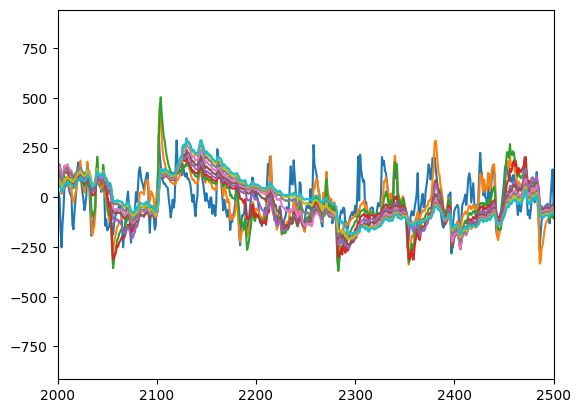

In [223]:

OHLC = Data[["BC","BL","BH","BO"]]


def sma_func(hyperparameter, data):
    # Calculate the Simple Moving Average (SMA) using the ta.sma() function
    close = data["BC"]
    sma_result = ta.sma(close, length=hyperparameter)-close

    # Convert the resulting Series to a NumPy array
    result_array = sma_result.to_numpy()

    return result_array

def stdev_func(hyperparameter, data):
    close = data["BC"]
    # Calculate the Simple Moving Average (SMA) using the ta.sma() function
    sma_result = ta.stdev(close, length=hyperparameter)

    # Convert the resulting Series to a NumPy array
    result_array = sma_result.to_numpy()

    return result_array

def rsi_func(hyperparameter, data):
    close = data["BC"]
    # Calculate the Simple Moving Average (SMA) using the ta.sma() function
    sma_result = ta.rsi(close, length=hyperparameter)

    # Convert the resulting Series to a NumPy array
    result_array = sma_result.to_numpy()

    return result_array

def cci_func(hyperparameter, data):
    close = data["BC"]
    high = data["BH"]
    low = data["BL"]
    # Calculate the Simple Moving Average (SMA) using the ta.sma() function
    sma_result = ta.cci(high,low,close, length=hyperparameter)

    # Convert the resulting Series to a NumPy array
    result_array = sma_result.to_numpy()

    return result_array


rsi = generate_dataframe(rsi_func,10,100,5,OHLC,"RSI_")

sma1 = generate_dataframe(sma_func,10,100,10,OHLC,"SMA_")
sma2 = generate_dataframe(sma_func,100,1000,50,OHLC,"SMA_")

stdev = generate_dataframe(stdev_func,10,300,10,OHLC,"STDEV_")

cci = generate_dataframe(cci_func,10,200,20,OHLC,"CCI_")


Technicals = pd.concat([sma1, sma2, stdev,rsi,cci], axis=1)

#print(stdev1)

plt.plot(cci)
plt.xlim(2000,2500)
#plt.ylim(-.05,.05)

**Combine dataframes and prepare data**

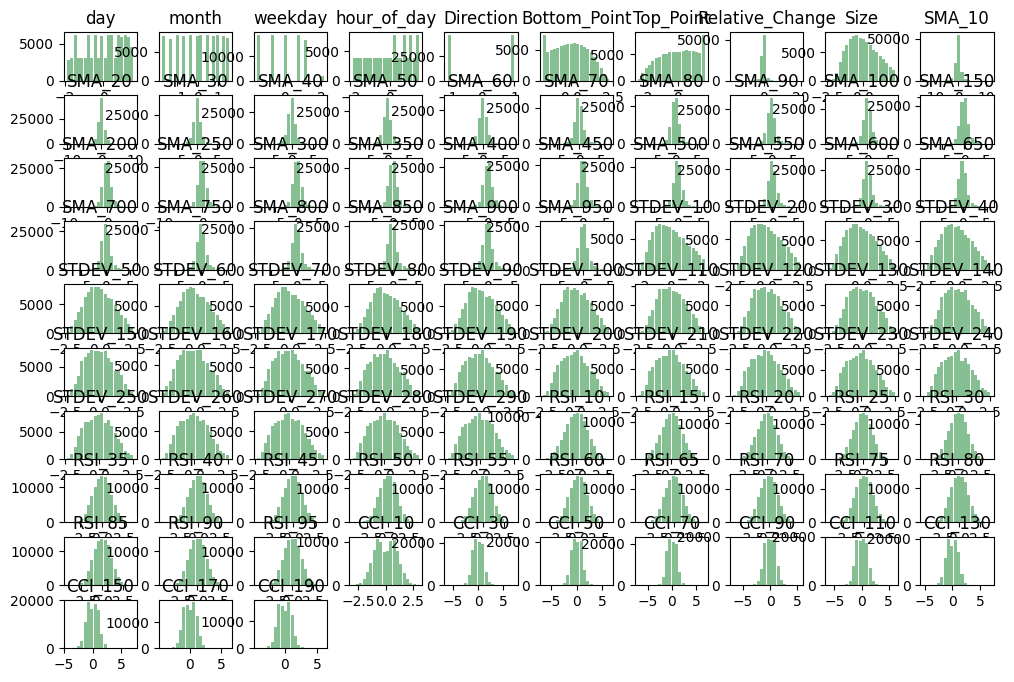

In [224]:
fulldata = pd.concat([Date,Shape,Technicals,],axis=1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(fulldata)
scaled_df = pd.DataFrame(scaled_data, columns=fulldata.columns)

pt = preprocessing.PowerTransformer(method='box-cox',standardize=True)

def boxcox_transform(df):
    pt = preprocessing.PowerTransformer(method='yeo-johnson',standardize=True)
    df_boxcox = pd.DataFrame(pt.fit_transform(df), columns=df.columns)
    return df_boxcox


newshoe = boxcox_transform(fulldata)

#print(fulldata)
#plt.plot(scaled_df)
hist = newshoe.hist(bins=20, figsize=(12, 8), grid=False, color='#86bf91', rwidth=0.9)
#plt.plot(newshoe)
plt.xlim(5000,5100)
plt.ylim(-5,5)
plt.show()

**Create target then remove nans from all data rows**

            day     month   weekday  hour_of_day  Direction  Bottom_Point  \
0      0.933067 -0.082954  1.227901     0.291716   0.999549      1.550749   
1      0.933067 -0.082954  1.227901     0.423681   0.999549      1.094693   
2      0.933067 -0.082954  1.227901     0.553240  -1.000451     -0.046221   
3      0.933067 -0.082954  1.227901     0.680584  -1.000451      1.104233   
4      0.933067 -0.082954  1.227901     0.805878  -1.000451      0.840879   
...         ...       ...       ...          ...        ...           ...   
61722  1.127179 -0.377740 -0.609407    -1.654604  -1.000451      0.447894   
61723  1.127179 -0.377740 -0.609407    -1.439834   0.999549      0.050228   
61724  1.127179 -0.377740 -0.609407    -1.244324  -1.000451     -1.250755   
61725  1.127179 -0.377740 -0.609407    -1.061990  -1.000451      0.887624   
61726  1.127179 -0.377740 -0.609407    -0.889514  -1.000451      0.383917   

       Top_Point  Relative_Change      Size    SMA_10  ...    CCI_10  \
0  

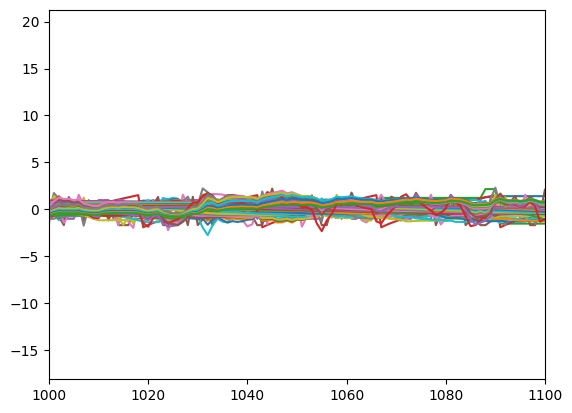

In [228]:
Target = pd.DataFrame()
Target["Target"] = Data['BC'] - Data['BO']

Target["Target"] = Target["Target"].shift(-1)


combine = pd.concat([Target,newshoe],axis=1)

combine = drop_rows_with_nan(combine)

Target = combine.pop("Target")

tester = Target

# Create MinMaxScaler object with desired scale range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the DataFrame
scaled_data = scaler.fit_transform(Target.values.reshape(-1, 1)).flatten()

# Convert the scaled data back to a DataFrame
Target = pd.DataFrame(data=scaled_data, columns=['Target'])


X_train, X_test, y_train, y_test = train_test_split(combine, Target, test_size=0.33, random_state=42,shuffle=False)

#plt.plot(tester*1000)
plt.plot(X_train)
plt.xlim(1000,1100)
print(X_train)


In [232]:
regulizer = l2(.001)

# create a sequential model
model = tf.keras.Sequential()

model.add(Dense(256, activation='gelu'))

model.add(Dense(128, activation='gelu',))

model.add(Dense(32, activation='gelu',))

model.add(Dense(1))

# compile the model with categorical crossentropy loss and Adam optimizer
model.compile(loss='mse', optimizer='adam')

In [ ]:
# train the model on your data
history = model.fit(X_train, y_train, epochs=10,batch_size=32,validation_data=(X_test, y_test))

Epoch 1/10
1929/1929 [==============================] - 9s 4ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 2/10
 233/1929 [==>...........................] - ETA: 5s - loss: 0.0036

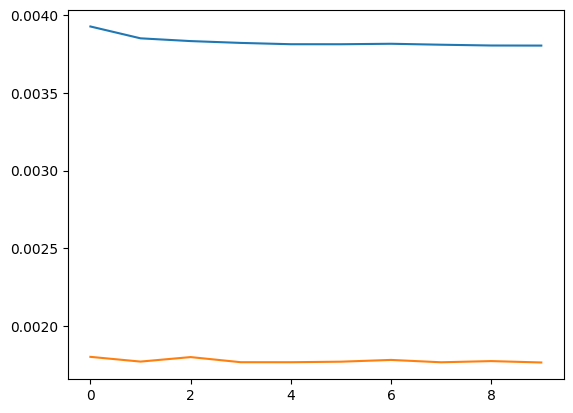

In [220]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

In [221]:
# Generate predictions on the test data
predictions = model.predict(X_test)



956/956 [==============================] - 4s 4ms/step


         Target
0     -0.078705
1     -0.184006
2     -0.088113
3     -0.027320
4      0.212231
...         ...
30563 -0.059888
30564 -0.080152
30565 -0.107653
30566 -0.091370
30567 -0.088113

[30568 rows x 1 columns]


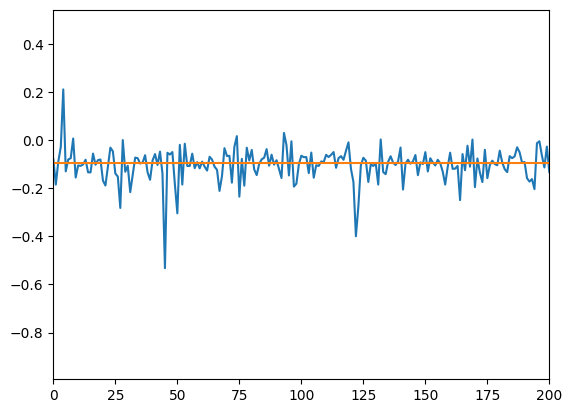

In [222]:


# set the index to start at 0
y_test.index = range(y_test.shape[0])
plt.plot(y_test)
plt.plot(predictions)
plt.xlim(0,200)
#plt.ylim(0,.01)
print(y_test)